**Import all the necessary libraries**

In [ ]:
# !pip install blis
# !pip install spacy
# python -m spacy download en_core_web_sm
# !pip uninstall pandas
# !pip install pandas==1.5 matplotlib==3.6
# !python -m spacy download en_core_web_sm
# !pip install streamlit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

**Importing The Data**

In [3]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake['Label']='Fake'
df_true['Label']='True'
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

**Observation:**

*Here we observe that nearly all of the true texts contain the word "Reuters". This presence may lead to overfitting during model training. Hence, we will need to remove it during the data preprocessing stage.*

In [4]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1
j

21247

**Manual Testing Dataset**

In [5]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

**Combining The Dataset**

In [6]:
df_train= pd.concat([df_fake, df_true], axis=0)
df_train

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [7]:
df_train=df_train.sample(frac=0.5)

**Preprocessing Data**

In [8]:
df_train.shape

(22438, 5)

In [9]:
df_train.describe()

,title,text,subject,date,Label
count,22438,22438,22438,22438,22438
unique,20835,20646,8,2358,2
top,Highlights: The Trump presidency on April 13 a...,,politicsNews,"December 20, 2017",Fake
freq,5,319,5609,90,11765


In [10]:
df_train.head(5)

,title,text,subject,date,Label
17654,WOW! JEB BUSH Claims Roy Moore Should “Step As...,"Monday on CNBC, former Gov. Jeb Bush (R-FL) sa...",left-news,"Nov 13, 2017",Fake
16040,Blast in Afghan capital causes numerous casual...,KABUL (Reuters) - A blast in the Afghan capita...,worldnews,"October 31, 2017",True
9452,Lawmakers vote down LGBT rights measure,"WASHINGTON (Reuters) - Shouts of “Shame, shame...",politicsNews,"May 19, 2016",True
3705,Trump’s New York Times Meeting Ends In DISAST...,Donald Trump s Tuesday meeting with The New Yo...,News,"November 22, 2016",Fake
13443,HYPOCRITES! CHECK OUT Massive Structure Party ...,It s interesting how the media has completely ...,politics,"Jul 24, 2016",Fake


In [11]:
df_train.fillna('', inplace=True)
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [12]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

In [13]:
df_train.reset_index(inplace=True)
df_train

,index,title,text,subject,date,Label
0,17654,WOW! JEB BUSH Claims Roy Moore Should “Step As...,"Monday on CNBC, former Gov. Jeb Bush (R-FL) sa...",left-news,"Nov 13, 2017",Fake
1,16040,Blast in Afghan capital causes numerous casual...,KABUL (Reuters) - A blast in the Afghan capita...,worldnews,"October 31, 2017",True
2,9452,Lawmakers vote down LGBT rights measure,"WASHINGTON (Reuters) - Shouts of “Shame, shame...",politicsNews,"May 19, 2016",True
3,3705,Trump’s New York Times Meeting Ends In DISAST...,Donald Trump s Tuesday meeting with The New Yo...,News,"November 22, 2016",Fake
4,13443,HYPOCRITES! CHECK OUT Massive Structure Party ...,It s interesting how the media has completely ...,politics,"Jul 24, 2016",Fake
...,...,...,...,...,...,...
22377,21629,THE DEMOCRAT WHO WROTE A PAPER About How Women...,The producers vs. the looters The man honeymoo...,left-news,"Jun 22, 2015",Fake
22378,17405,5-Star Mooch and Free-Loading Granny Drop In F...,Nothing but the best for the queen and the que...,Government News,"Apr 20, 2015",Fake
22379,18375,Spain's King condemns Catalan leaders as thous...,BARCELONA (Reuters) - Spain s King Felipe VI o...,worldnews,"October 3, 2017",True
22380,5149,Pence used private email while Indiana governor,WASHINGTON (Reuters) - U.S. Vice President Mik...,politicsNews,"March 3, 2017",True


**Code to Remove the word "Reuter"**

In [14]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text
df_train['text']=df_train['text'].apply(reuters_removal)

In [15]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1

j

5

**Data Visualization**

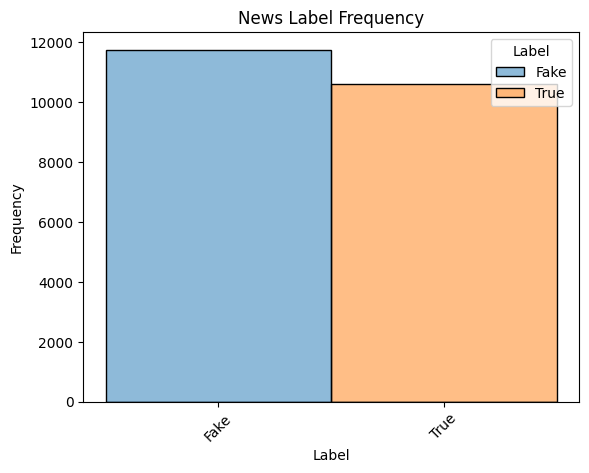

In [16]:
sbs.histplot(x='Label', hue='Label',data=df_train)
plt.title('News Label Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency');

In [17]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

politicsNews       5590
worldnews          5028
News               4527
politics           3423
left-news          2244
Government News     794
US_News             395
Middle-east         381
Name: subject, dtype: int64

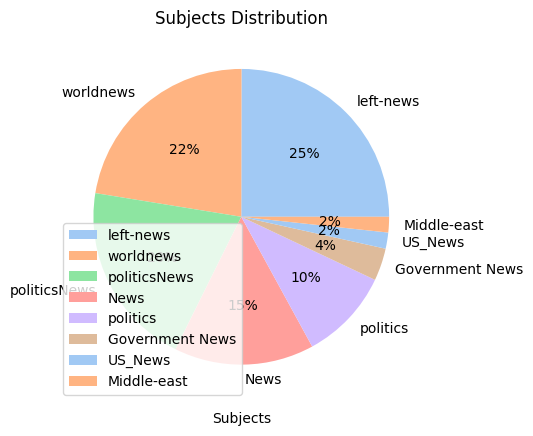

In [18]:
colors = sbs.color_palette('pastel')[0:6]
plt.pie(df_top_group,labels=df_top.subject.unique(),autopct='%.0f%%', colors=colors)
plt.title('Subjects Distribution')
plt.xlabel('Subjects')
plt.legend(df_top.subject.unique(), loc='lower left')
plt.show();

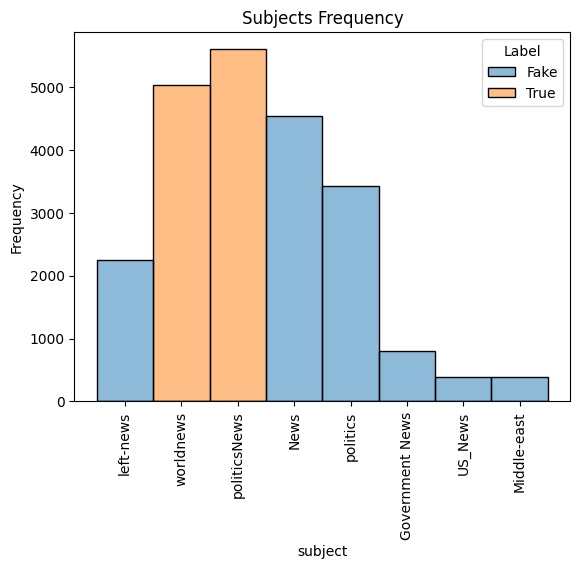

In [19]:
top_parties = df_train['subject'].value_counts().nlargest(5).index
df_top=df_train.copy()
df_top.loc[~df_top['subject'].isin(top_parties), 'Party'] = 'Other'
sbs.histplot(x='subject', hue='Label', data=df_top, stat='count')
plt.title('Subjects Frequency')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show();

In [20]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

**Splitting The Data**

*We will split the dataset into training and testing sets. Additionally, we will encode the labels into numerical values to facilitate the calculation of the reliability percentage of the news articles.*

In [21]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)
y.unique()

array(['Fake', 'True'], dtype=object)

In [22]:
X

,title,text,subject
0,WOW! JEB BUSH Claims Roy Moore Should “Step As...,"Monday on CNBC, former Gov. Jeb Bush (R-FL) sa...",left-news
1,Blast in Afghan capital causes numerous casual...,KABUL - A blast in the Afghan capital Kabul on...,worldnews
2,Lawmakers vote down LGBT rights measure,"WASHINGTON - Shouts of “Shame, shame, shame,” ...",politicsNews
3,Trump’s New York Times Meeting Ends In DISAST...,Donald Trump s Tuesday meeting with The New Yo...,News
4,HYPOCRITES! CHECK OUT Massive Structure Party ...,It s interesting how the media has completely ...,politics
...,...,...,...
22377,THE DEMOCRAT WHO WROTE A PAPER About How Women...,The producers vs. the looters The man honeymoo...,left-news
22378,5-Star Mooch and Free-Loading Granny Drop In F...,Nothing but the best for the queen and the que...,Government News
22379,Spain's King condemns Catalan leaders as thous...,BARCELONA - Spain s King Felipe VI on Tuesday ...,worldnews
22380,Pence used private email while Indiana governor,WASHINGTON - U.S. Vice President Mike Pence us...,politicsNews


**Stemming and Stop Words**

In [23]:
port_stemmer= PorterStemmer()
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def stemmer(text):
    # Process the text
    doc = nlp(text)

    # Extract the lemma of each token if it is not a stopword or punctuation
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
X['text']= X['text'].apply(stemmer)
X=X['text']
X

0        Monday CNBC Gov. Jeb Bush R FL say sexual misc...
1        KABUL blast afghan capital Kabul Tuesday cause...
2        WASHINGTON Shouts Shame shame shame erupt U.S....
3        Donald Trump s Tuesday meeting New York Times ...
4        s interesting medium completely ignore massive...
                               ...                        
22377    producer vs. looter man honeymoon communist co...
22378    good queen queen s mom mother law President hi...
22379    BARCELONA Spain s King Felipe VI Tuesday accus...
22380    WASHINGTON U.S. Vice President Mike Pence priv...
22381    CHENGDU China stepfather die pulmonary heart d...
Name: text, Length: 22382, dtype: object

**Train Test Split**

In [25]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=40, stratify=y)

**TF-IDF Vectorization**

*TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to represent text data numerically*

In [26]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

**Model Training Using Logistic Regression**

In [27]:
lgr=LogisticRegression(max_iter=1000)
lgr.fit(xv_train,y_train)

LogisticRegression(max_iter=1000)

In [28]:
y_pred=lgr.predict(xv_test)
acc = accuracy_score(y_pred,y_test)
print("Accuracy: ", round(acc*100,1 ), "%")
print(classification_report(y_test, y_pred))

Accuracy:  97.7 %
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      2353
        True       0.97      0.98      0.98      2124

    accuracy                           0.98      4477
   macro avg       0.98      0.98      0.98      4477
weighted avg       0.98      0.98      0.98      4477



**Testing**

In [29]:
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(reuters_removal)

    new_def_test["text"] = new_def_test["text"].apply(stemmer)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    prediction= lgr.predict(new_xv_test)
    return prediction[0]
manual_testing(df_manual.loc[12,'text'])

'True'

In [36]:
sample_text = "As we have become accustomed to, when Arsenal are in need, up steps No. 7 and Bukayo Saka tore apart Southamption at the Emirates, much to the delight of Mikel Arteta."
print("Predicted category:", manual_testing(sample_text))

Predicted category: Fake


In [30]:
df_manual

,title,text,subject,date,Label
0,"Did Ron Paul Just Confuse Al-Qaeda With ISIS,...",Former Texas Congressman Ron Paul added yet mo...,News,"August 22, 2017",Fake
1,Congressional Black Caucus Signals That They ...,"The Congressional Black Caucus, like most Demo...",News,"August 21, 2017",Fake
2,Body-Slamming Republican Thought He Was Too I...,"You may remember Greg Gianforte, the Republica...",News,"August 21, 2017",Fake
3,Ron Paul Blames Obama For A Stock Market Cras...,"Ron Paul, who s a retired doctor, not an econo...",News,"August 21, 2017",Fake
4,GOP Lawmaker Blames Obama For Staging Racist ...,"According to Republican lawmaker from Idaho, i...",News,"August 21, 2017",Fake
5,Twitter Has Absolute Field Day Laughing At Tr...,Scientists have been warning the world for wee...,News,"August 21, 2017",Fake
6,Donald Trump Never Met A Disaster He Couldn’t...,Back when conservative politics were actually ...,News,"August 21, 2017",Fake
7,Thousands Of Advertisers Are Fleeing From Fak...,Donald Trump s former Chief Strategist Stephen...,News,"August 21, 2017",Fake
8,Trump’s Response To USS John S. McCain Collis...,It s common knowledge that Donald Trump is a s...,News,"August 21, 2017",Fake
9,Secret Service Officially Can’t Afford To Pay...,Donald Trump has been wasting taxpayer dollars...,News,"August 21, 2017",Fake


In [32]:
import pickle
filename = 'trained_model.sav'
pickle.dump(lgr, open(filename, 'wb'))


In [33]:
loaded_model = pickle.load(open('trained_model.sav', 'rb'))